<a href="https://colab.research.google.com/github/s-ajmal/FSS/blob/main/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explainable AI**

Connect to google drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [7]:
import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/XAI')
!ls

checkpoint.pth	food  XAI.ipynb


## Environment settings

In [ ]:
# download and unzip training data
!gdown '1cYBWwYab3djiaYuOU6CxkYHQyUYws4Ce' --output food.zip
!unzip food.zip

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1cYBWwYab3djiaYuOU6CxkYHQyUYws4Ce

but Gdown can't. Please check connections and permissions.
unzip:  cannot find or open food.zip, food.zip.zip or food.zip.ZIP.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# download pretrained model
!gdown --id '1CShZHsO8oAZwxQkMe7jRtEgSNb2w_OZu' --output checkpoint.pth

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Error:

	[Errno 107] Transport endpoint is not connected: '.'

To report issues, please visit https://github.com/wkentaro/gdown/issues.


In [10]:
# install lime in colab
!pip install lime==0.1.1.37

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.0/276.0 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.1.1.37-py3-none-any.whl size=284262 sha256=72eda2803afeeee42fe6f6920dfd42a9ccd31236c5de2089827086db752b06f0
  Stored in directory: /root/.cache/pip/wheels/c0/48/6c/2437c474145e879ae415fdce78be1ea7dc7e81f7f26900c667
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12067 sha256=c3106991590b0dd9f87745e795e6b12b0d6e682a79351dd8040bcca3806d6715
  Stored in directory: /root/.cache/pip/wheels/cd/17/e5/765d1a3112ff3978f70223502f6047e06c43a24d7c5f8ff95b
Successfully built lime progressbar


## Start our python script

In [11]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace
from torch.autograd import Variable

## Argument parsing

In [15]:
args = {
      'ckptpath': '/content/drive/MyDrive/Colab Notebooks/XAI/checkpoint.pth',
      'dataset_dir': '/content/drive/MyDrive/Colab Notebooks/XAI/food'
}
args = argparse.Namespace(**args)

## Model definition and checkpoint loading

In [16]:
# Model definition
class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()

    def building_block(indim, outdim):
      return [
        nn.Conv2d(indim, outdim, 3, 1, 1),
        nn.BatchNorm2d(outdim),
        nn.ReLU(),
      ]
    def stack_blocks(indim, outdim, block_num):
      layers = building_block(indim, outdim)
      for i in range(block_num - 1):
        layers += building_block(outdim, outdim)
      layers.append(nn.MaxPool2d(2, 2, 0))
      return layers

    cnn_list = []
    cnn_list += stack_blocks(3, 128, 3)
    cnn_list += stack_blocks(128, 128, 3)
    cnn_list += stack_blocks(128, 256, 3)
    cnn_list += stack_blocks(256, 512, 1)
    cnn_list += stack_blocks(512, 512, 1)
    self.cnn = nn.Sequential( * cnn_list)

    dnn_list = [
      nn.Linear(512 * 4 * 4, 1024),
      nn.ReLU(),
      nn.Dropout(p = 0.3),
      nn.Linear(1024, 11),
    ]
    self.fc = nn.Sequential( * dnn_list)

  def forward(self, x):
    out = self.cnn(x)
    out = out.reshape(out.size()[0], -1)
    return self.fc(out)

In [17]:
# Load trained model
model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
model.load_state_dict(checkpoint['model_state_dict'])
# It should display: <All keys matched successfully>

<All keys matched successfully>

## Dataset definition and creation

In [18]:
# It might take some time, if it is too long, try to reload it.
# Dataset definition
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'

        self.paths = paths
        self.labels = labels
        trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evalTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = trainTransform if mode == 'train' else evalTransform

    # pytorch dataset class
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # help to get images for visualizing
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
          image, label = self.__getitem__(index)
          images.append(image)
          labels.append(label)
        return torch.stack(images), torch.tensor(labels)

# help to get data path and label
def get_paths_labels(path):
    def my_key(name):
      return int(name.replace(".jpg",""))+1000000*int(name.split("_")[0])
    imgnames = os.listdir(path)
    imgnames.sort(key=my_key)
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels
train_paths, train_labels = get_paths_labels(args.dataset_dir)

train_set = FoodDataset(train_paths, train_labels, mode='eval')

## Start XAI Homework

## The images for observation

There are 11 categories of food: Bread, Dairy product, Dessert, Egg, Fried food, Meat, Noodles/Pasta, Rice, Seafood, Soup, and Vegetable/Fruit.

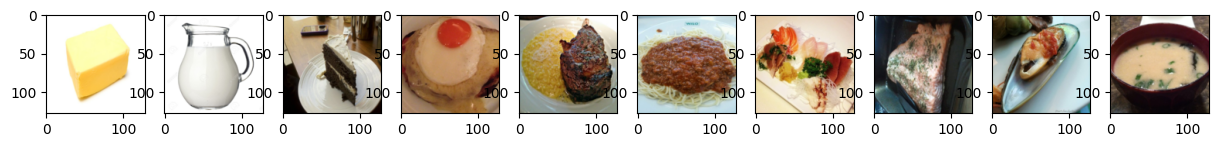

In [19]:
img_indices = [i for i in range(10)]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[i].imshow(img.cpu().permute(1, 2, 0))
# print(labels)

## Lime

[Lime](https://github.com/marcotcr/lime.git) is a package about explaining what machine learning classifiers are doing. We can first use it to observe the model.

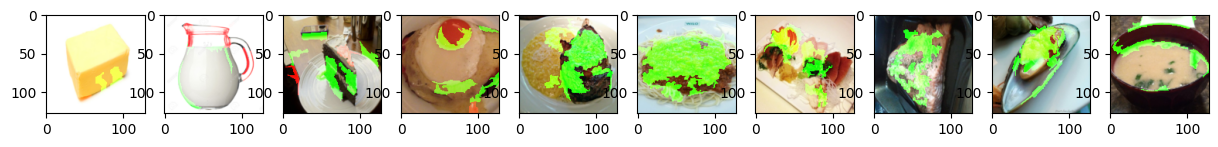

In [20]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)

    model.eval()
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)
    # pytorch tensor, (batches, channels, height, width)

    output = model(input.cuda())
    return output.detach().cpu().numpy()

def segmentation(input):
    # split the image into 200 pieces with the help of segmentaion from skimage
    return slic(input, n_segments=200, compactness=1, sigma=1)


fig, axs = plt.subplots(1, len(img_indices), figsize=(15, 8))
# fix the random seed to make it reproducible
np.random.seed(16)
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):
    x = image.astype(np.double)
    # numpy array for lime

    explainer = lime_image.LimeImageExplainer()
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)

    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=explain_instance#lime.lime_image.LimeImageExplainer.explain_instance

    lime_img, mask = explaination.get_image_and_mask(
                                label=label.item(),
                                positive_only=False,
                                hide_rest=False,
                                num_features=11,
                                min_weight=0.05
                            )
    # turn the result from explainer to the image
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask

    axs[idx].imshow(lime_img)

plt.show()
plt.close()

### What is Saliency map
Saliency: 顯著性

The heatmaps that highlight pixels of the input image that contribute the most in the classification task.

Ref: https://medium.com/datadriveninvestor/visualizing-neural-networks-using-saliency-maps-in-pytorch-289d8e244ab4

### Saliency map

We put an image into the model, forward then calculate the loss referring to the label. Therefore, the loss is related to:
- image
- model parameters
- label

Generally speaking, we change model parameters to fit "image" and "label". When backward, we calculate the partial differential value of **loss to model parameters**.

Now, we have another look. When we change the image's pixel value, the partial differential value of **loss to image** shows the change in the loss. We can say that it means the importance of the pixel. We can visualize it to demonstrate which part of the image contribute the most to the model's judgement.

In [21]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())
  # return torch.log(image)/torch.log(image.max())

def compute_saliency_maps(x, y, model):
  model.eval()
  x = x.cuda()

  # we want the gradient of the input x
  x.requires_grad_()

  y_pred = model(x)
  loss_func = torch.nn.CrossEntropyLoss()
  loss = loss_func(y_pred, y.cuda())
  loss.backward()

  # saliencies = x.grad.abs().detach().cpu()
  saliencies, _ = torch.max(x.grad.data.abs().detach().cpu(),dim=1)

  # We need to normalize each image, because their gradients might vary in scale, but we only care about the relation in each image
  saliencies = torch.stack([normalize(item) for item in saliencies])
  return saliencies

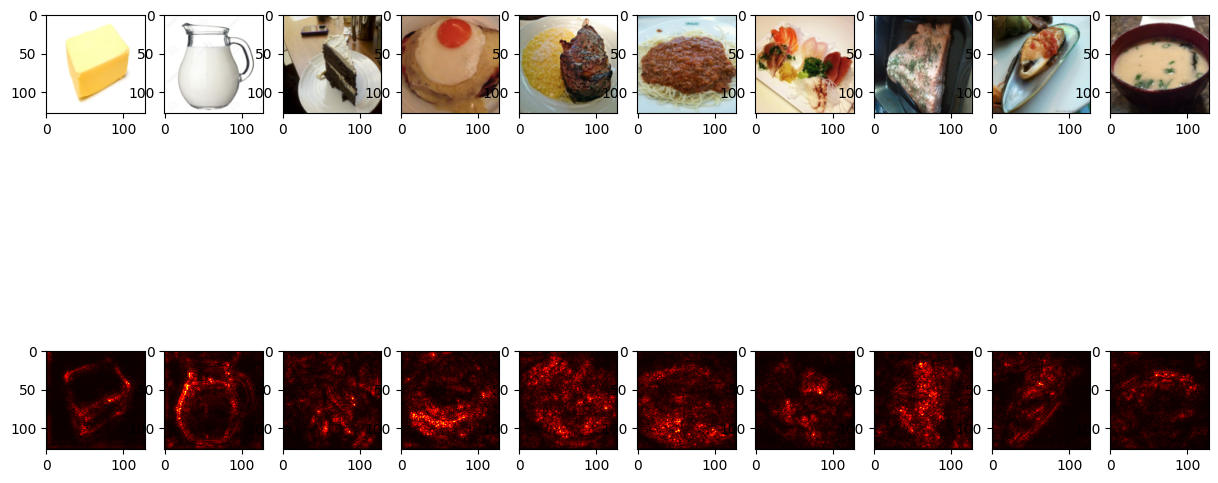

In [22]:
# images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# visualize
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
  for column, img in enumerate(target):
    if row==0:
      axs[row][column].imshow(img.permute(1, 2, 0).numpy())
      # What is permute?
      # In pytorch, the meaning of each dimension of image tensor is (channels, height, width)
      # In matplotlib, the meaning of each dimension of image tensor is (height, width, channels)
      # permute is a tool for permuting dimensions of tensors
      # For example, img.permute(1, 2, 0) means that,
      # - 0 dimension is the 1 dimension of the original tensor, which is height
      # - 1 dimension is the 2 dimension of the original tensor, which is width
      # - 2 dimension is the 0 dimension of the original tensor, which is channels
    else:
      axs[row][column].imshow(img.numpy(), cmap=plt.cm.hot)

plt.show()
plt.close()

### Smooth grad

Smooth grad 的方法是，在圖片中隨機地加入 noise，然後得到不同的 heatmap，把這些 heatmap 平均起來就得到一個比較能抵抗 noisy gradient 的結果。

The method of Smooth grad is randomly adding noise to the image and get different heatmaps. The average of the heatmaps would be more robust to noisy gradient.

ref: https://arxiv.org/pdf/1706.03825.pdf

(10, 1, 3, 128, 128)


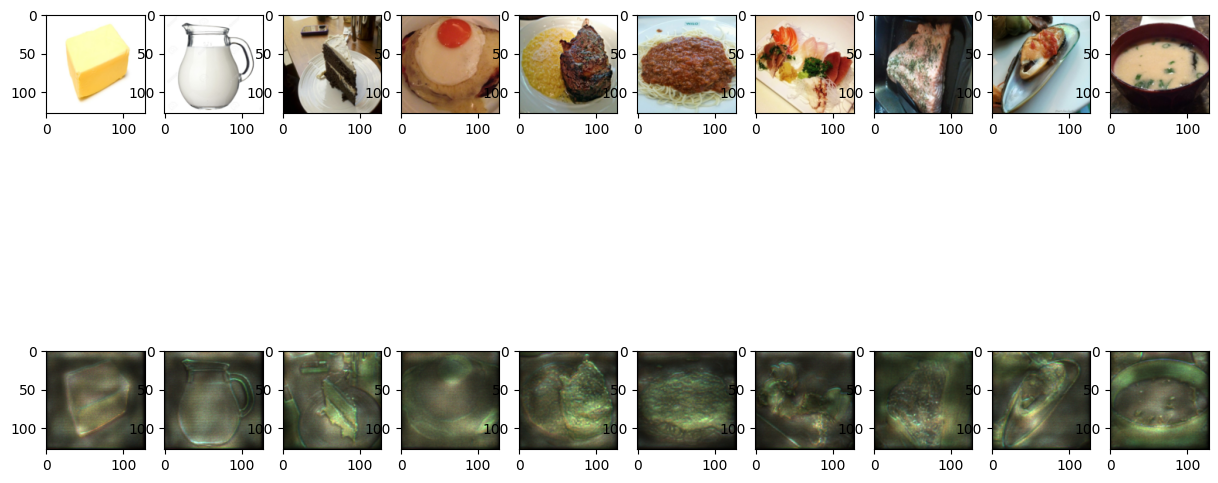

In [24]:
# Smooth grad

def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

def smooth_grad(x, y, model, epoch, param_sigma_multiplier):
  model.eval()
  #x = x.cuda().unsqueeze(0)

  mean = 0
  sigma = param_sigma_multiplier / (torch.max(x) - torch.min(x)).item()
  smooth = np.zeros(x.cuda().unsqueeze(0).size())
  for i in range(epoch):
    # call Variable to generate random noise
    noise = Variable(x.data.new(x.size()).normal_(mean, sigma**2))
    x_mod = (x+noise).unsqueeze(0).cuda()
    x_mod.requires_grad_()

    y_pred = model(x_mod)
    loss_func = torch.nn.CrossEntropyLoss()
    loss = loss_func(y_pred, y.cuda().unsqueeze(0))
    loss.backward()

    # like the method in saliency map
    smooth += x_mod.grad.abs().detach().cpu().data.numpy()
  smooth = normalize(smooth / epoch) # don't forget to normalize
  # smooth = smooth / epoch
  return smooth

# images, labels = train_set.getbatch(img_indices)
smooth = []
for i, l in zip(images, labels):
  smooth.append(smooth_grad(i, l, model, 500, 0.4))
smooth = np.stack(smooth)
print(smooth.shape)

fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, smooth]):
  for column, img in enumerate(target):
    axs[row][column].imshow(np.transpose(img.reshape(3,128,128), (1,2,0)))




## Filter explanation

這裡我們想要知道某一個 filter 到底認出了什麼。我們會做以下兩件事情：
- Filter activation: 挑幾張圖片出來，看看圖片中哪些位置會 activate 該 filter
- Filter visualization: 怎樣的 image 可以最大程度的 activate 該 filter

In this part, we want to know what a specific filter recognize, we'll do
- Filter activation: pick up some images, check which part of the image will activate the filter
- Filter visualization: which kind of image can activate the filter the most

實作上比較困難的地方是，通常我們是直接把 image 丟進 model，一路 forward 到底。如：

The problem is that, in normal case, we'll directly feed the image to the model, for example,
```
loss = model(image)
loss.backward()
```
我們要怎麼得到中間某層 CNN 的 output? 當然我們可以直接修改 model definition，讓 forward 不只 return loss，也 return activation map。但這樣的寫法麻煩了，更改了 forward 的 output 可能會讓其他部分的 code 要跟著改動。因此 pytorch 提供了方便的 solution: **hook**，以下我們會再介紹。

How can we get the output of a specific layer of CNN? We can modify the model definition, make the forward function not only return loss but also retrun the activation map. But this is difficult to maintain the code. As a result, pytorch offers a better solution: **hook**


In [25]:
model

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [26]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explanation(x, model, cnnid, filterid, iteration=100, lr=1):
  # x: input image
  # cnnid, filterid: cnn layer id, which filter
  model.eval()

  def hook(model, input, output):
    global layer_activations
    layer_activations = output

  hook_handle = model.cnn[cnnid].register_forward_hook(hook)
  # When the model forward through the layer[cnnid], need to call the hook function first
  # The hook function save the output of the layer[cnnid]
  # After forwarding, we'll have the loss and the layer activation

  # Filter activation: x passing the filter will generate the activation map
  model(x.cuda()) # forward

  # Based on the filterid given by the function argument, pick up the specific filter's activation map
  # We just need to plot it, so we can detach from graph and save as cpu tensor
  filter_activations = layer_activations[:, filterid, :, :].detach().cpu()

  # Filter visualization: find the image that can activate the filter the most
  x = x.cuda()
  x.requires_grad_()
  # input image gradient
  optimizer = Adam([x], lr=lr)
  # Use optimizer to modify the input image to amplify filter activation
  for iter in range(iteration):
    optimizer.zero_grad()
    model(x)

    objective = -layer_activations[:, filterid, :, :].sum()
    # We want to maximize the filter activation's summation
    # So we add a negative sign

    objective.backward()
    # Calculate the partial differential value of filter activation to input image
    optimizer.step()
    # Modify input image to maximize filter activation
  filter_visualizations = x.detach().cpu().squeeze()

  # Don't forget to remove the hook
  hook_handle.remove()
  # The hook will exist after the model register it, so you have to remove it after used
  # Just register a new hook if you want to use it

  return filter_activations, filter_visualizations

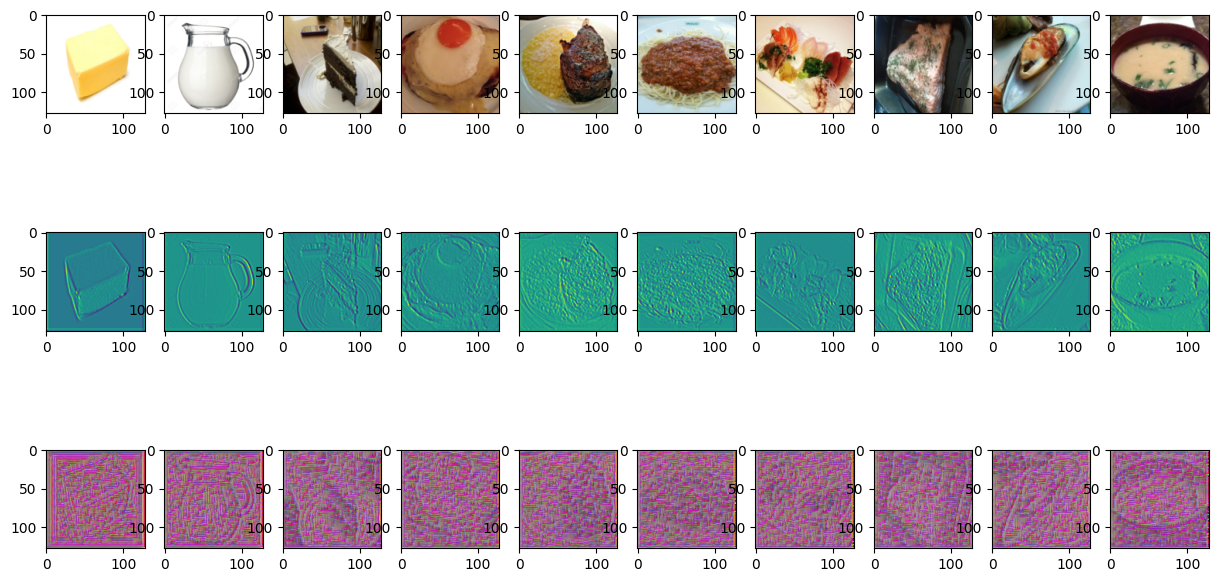

In [27]:
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=6, filterid=0, iteration=100, lr=0.1)


fig, axs = plt.subplots(3, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
# Plot filter activations
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
# Plot filter visualization
for i, img in enumerate(filter_visualizations):
  axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
plt.close()

# 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界

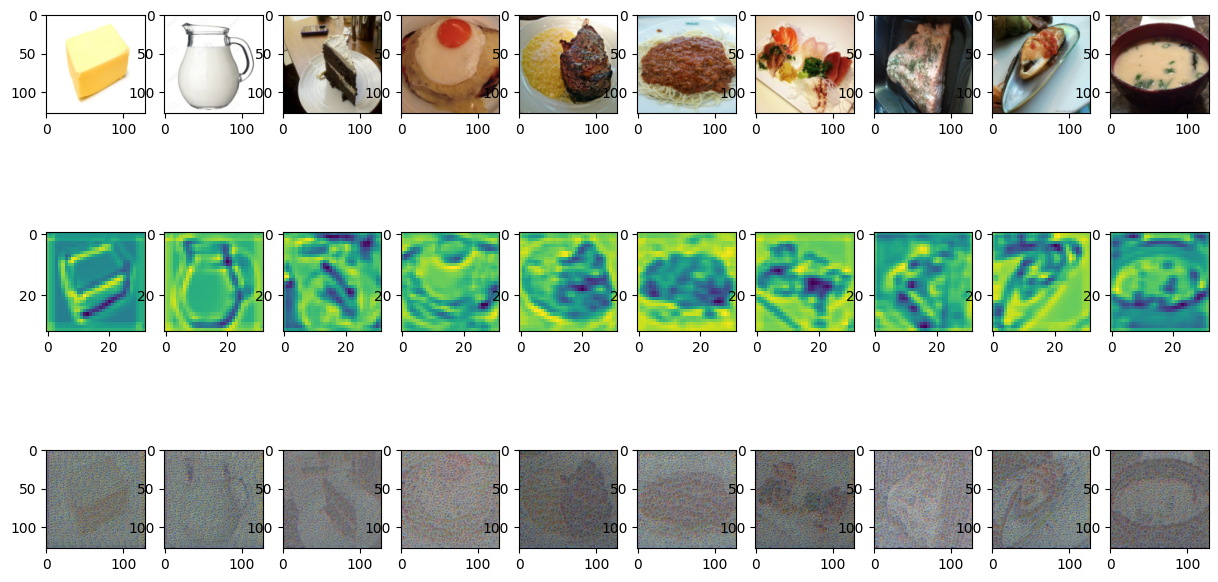

In [28]:
images, labels = train_set.getbatch(img_indices)
filter_activations, filter_visualizations = filter_explanation(images, model, cnnid=23, filterid=0, iteration=100, lr=0.1)

# Plot filter activations
fig, axs = plt.subplots(3, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.permute(1, 2, 0))
for i, img in enumerate(filter_activations):
  axs[1][i].imshow(normalize(img))
for i, img in enumerate(filter_visualizations):
  axs[2][i].imshow(normalize(img.permute(1, 2, 0)))
plt.show()
plt.close()


## Integrated Gradient



In [29]:
class IntegratedGradients():
    def __init__(self, model):
        self.model = model
        self.gradients = None
        # Put model in evaluation mode
        self.model.eval()

    def generate_images_on_linear_path(self, input_image, steps):
        # Generate scaled xbar images
        xbar_list = [input_image*step/steps for step in range(steps)]
        return xbar_list

    def generate_gradients(self, input_image, target_class):
        # We want to get the gradients of the input image
        input_image.requires_grad=True
        # Forward
        model_output = self.model(input_image)
        # Zero grads
        self.model.zero_grad()
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_().cuda()
        one_hot_output[0][target_class] = 1
        # Backward
        model_output.backward(gradient=one_hot_output)
        self.gradients = input_image.grad
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,128,128)
        gradients_as_arr = self.gradients.data.cpu().numpy()[0]
        return gradients_as_arr

    def generate_integrated_gradients(self, input_image, target_class, steps):
        # Generate xbar images
        xbar_list = self.generate_images_on_linear_path(input_image, steps)
        # Initialize an iamge composed of zeros
        integrated_grads = np.zeros(input_image.size())
        for xbar_image in xbar_list:
            # Generate gradients from xbar images
            single_integrated_grad = self.generate_gradients(xbar_image, target_class)
            # Add rescaled grads from xbar images
            integrated_grads = integrated_grads + single_integrated_grad/steps
        # [0] to get rid of the first channel (1,3,128,128)
        return integrated_grads[0]

def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

In [30]:
# put the image to cuda
images, labels = train_set.getbatch(img_indices)
images = images.cuda()

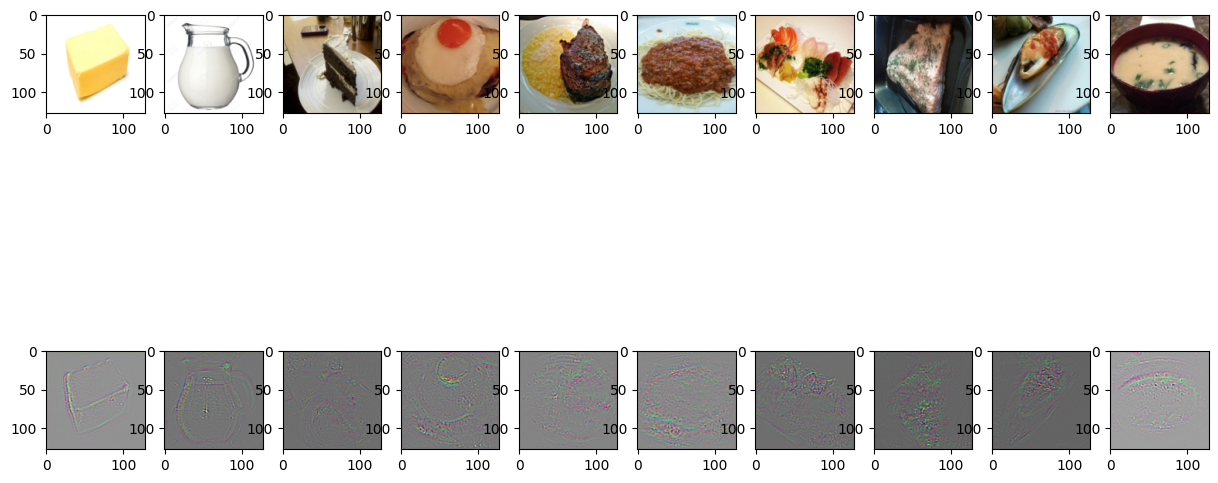

In [31]:
IG = IntegratedGradients(model)
integrated_grads = []
for i, img in enumerate(images):
  img = img.unsqueeze(0)
  integrated_grads.append(IG.generate_integrated_gradients(img, labels[i], 10))
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for i, img in enumerate(images):
  axs[0][i].imshow(img.cpu().permute(1, 2, 0))
for i, img in enumerate(integrated_grads):
  axs[1][i].imshow(np.moveaxis(normalize(img),0,-1))
plt.show()
plt.close()